In [1]:
import tensorflow as tf
print(tf.__version__)
tf.enable_eager_execution()
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import numpy as np
import tensorflow_datasets as tfds

1.14.0


In [0]:
# define the hyperparams
vocab_size=10000
emb_dim=32
max_length=120
pad_type='pre'
trunc_type='post'
oov_tag='<OOV>'

In [3]:
imdb,info=tfds.load('imdb_reviews',with_info=True,as_supervised=True)
train_data,test_data=imdb["train"],imdb["test"]

W0714 07:01:58.775930 140366984750976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


W0714 07:02:44.125688 140366984750976 dataset_builder.py:384] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


In [0]:
train_sent=[]
train_label=[]
valid_sent=[]
valid_label=[]

for s,l in train_data:
  train_sent.append(str(s.numpy()))
  train_label.append(l.numpy())

for s,l in test_data:
  valid_sent.append(str(s.numpy()))
  valid_label.append(l.numpy())

train_label=np.array(train_label)
valid_label=np.array(valid_label)

In [0]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tag)
tokenizer.fit_on_texts(train_sent)
word_index=tokenizer.word_index
train_sequence=tokenizer.texts_to_sequences(train_sent)
train_padded=pad_sequences(train_sequence,padding=pad_type,truncating=trunc_type,maxlen=max_length)
valid_sequence=tokenizer.texts_to_sequences(valid_sent)
valid_padded=pad_sequences(valid_sequence,padding=pad_type,truncating=trunc_type,maxlen=max_length)

In [0]:
inverse_word_index={word_index[k]:k for k in word_index.keys()}

In [0]:
def decode(sequence):
  return ' '.join([inverse_word_index.get(v,'<unk>') for v in sequence])

In [8]:
print(train_sent[1])
print(decode(train_padded[1]))

b"This was soul-provoking! I am an Iranian, and living in th 21st century, I didn't know that such big tribes have been living in such conditions at the time of my grandfather!<br /><br />You see that today, or even in 1925, on one side of the world a lady or a baby could have everything served for him or her clean and on-demand, but here 80 years ago, people ventured their life to go to somewhere with more grass. It's really interesting that these Persians bear those difficulties to find pasture for their sheep, but they lose many the sheep on their way.<br /><br />I praise the Americans who accompanied this tribe, they were as tough as Bakhtiari people."
b this was soul provoking i am an iranian and living in <OOV> 21st century i didn't know that such big <OOV> have been living in such conditions at the time of my grandfather br br you see that today or even in <OOV> on one side of the world a lady or a baby could have everything served for him or her clean and on demand but here 80 

In [0]:
#building the model
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,emb_dim,input_length=max_length),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 32)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 329,409
Trainable params: 329,409
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
num_epoch=15
history=model.fit(train_padded,train_label,validation_data=(valid_padded,valid_label),epochs=num_epoch)

Train on 25000 samples, validate on 25000 samples


W0714 07:10:21.927067 140366984750976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
25000/25000 [==============================] - 532s 21ms/sample - loss: 0.4829 - acc: 0.7532 - val_loss: 0.4132 - val_acc: 0.8046
Epoch 2/15
25000/25000 [==============================] - 524s 21ms/sample - loss: 0.2967 - acc: 0.8792 - val_loss: 0.4467 - val_acc: 0.8218
Epoch 3/15
25000/25000 [==============================] - 529s 21ms/sample - loss: 0.2288 - acc: 0.9106 - val_loss: 0.4262 - val_acc: 0.8143
Epoch 4/15
25000/25000 [==============================] - 527s 21ms/sample - loss: 0.1798 - acc: 0.9327 - val_loss: 0.5467 - val_acc: 0.8106
Epoch 5/15
25000/25000 [==============================] - 524s 21ms/sample - loss: 0.1376 - acc: 0.9493 - val_loss: 0.5993 - val_acc: 0.7966
Epoch 6/15
25000/25000 [==============================] - 522s 21ms/sample - loss: 0.1117 - acc: 0.9602 - val_loss: 0.7428 - val_acc: 0.7946
Epoch 7/15
25000/25000 [==============================] - 519s 21ms/sample - loss: 0.0848 - acc: 0.9710 - val_loss: 0.8305 - val_acc: 0.7952
Epoch 8/15
25

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

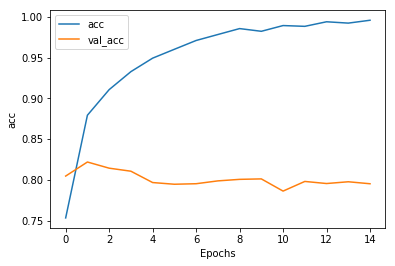

In [16]:
plot_graphs(history, 'acc')

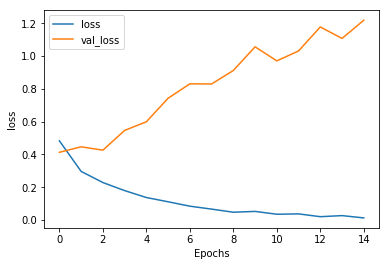

In [15]:
plot_graphs(history, 'loss')